In [1]:
import sys
print(sys.executable)

%load_ext autoreload
%autoreload 2

/Users/BERL/Github/venv_sksparse/bin/python3.11


In [2]:
import numpy as np
import scipy as sp
import networkx as nx
from gstools import SRF, Exponential
from gstools.random import MasterRNG
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets
import plotly.graph_objects as go
from tqdm import tqdm

from graphite_maps.enif import EnIF
from iterative_ensemble_smoother.experimental import AdaptiveESMDA

In [3]:
def plot_field(i, title):
    plt.figure(figsize=(5, 5))
    # Find global min and max across all fields to set color scale
    vmin = np.min([np.min(u) for u in field])
    vmax = np.max([np.max(u) for u in field])
    plt.imshow(field[i], cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f"{title} {i}")
    plt.colorbar()
    plt.show

def create_flattened_graph(px, py):
    G = nx.Graph()
    for i in range(px):
        for j in range(py):
            index = i * py + j  # Flatten the 2D index to a single index
            # Connect to the right neighbor
            if j < py - 1:
                G.add_edge(index, index + 1)
            # Connect to the bottom neighbor
            if i < px - 1:
                G.add_edge(index, index + py)
    return G

def draw_2d_grid_graph(G, dim_x, dim_y, node_size=50):
    pos = {node: (node % dim_y, node // dim_y) for node in G.nodes()}
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=node_size)
    plt.show()

def plot_field_from_vector(U_i, px, py, vmin, vmax, title="2D Field"):
    """
    Plots a 2D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create the plot
    plt.figure(figsize=(6, 5))
    plt.imshow(field_2d, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('X dimension')
    plt.ylabel('Y dimension')
    plt.show()

def plot_field_3d(U_i, px, py, vmin, vmax, title="3D Field", azim=30):
    """
    Plots a 3D field from a flattened realization.

    Parameters:
    - U_i: A flattened 2D field (1D numpy array).
    - px: The x-dimension (width) of the original 2D field.
    - py: The y-dimension (height) of the original 2D field.
    - vmin: Minimum value for colormap and z-axis.
    - vmax: Maximum value for colormap and z-axis.
    - title: Title of the plot.
    """
    # Reshape U_i into its original 2D form
    field_2d = U_i.reshape((px, py))
    
    # Create meshgrid for x and y dimensions
    x = np.linspace(0, px-1, px)
    y = np.linspace(0, py-1, py)
    X, Y = np.meshgrid(x, y)
    
    # Create the plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    surf = ax.plot_surface(X, Y, field_2d.T, cmap='viridis', edgecolor='none', vmin=vmin, vmax=vmax)
    
    # Add a color bar
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Value')
    
    ax.set_title(title)
    ax.set_xlabel('X dimension')
    ax.set_ylabel('Y dimension')
    ax.set_zlabel('Values')
    ax.set_zlim(vmin, vmax)

    # Set the view angle
    ax.view_init(azim=azim)
    
    plt.show()

In [4]:
px, py = 50, 50
p = px * py
n = 100

# Anisotropic exponential covariance Gaussian field

- variance $\sigma^2=1$
- correlation length $\lambda = (12,3)^T$
- rotation angle $\phi = \pi/8$

see [GSTools tutorial](https://geostat-framework.readthedocs.io/projects/gstools/en/v1.1.1/tutorial_01_srf.html#creating-fancier-fields)

In [5]:
model = Exponential(dim=2, var=1, len_scale=[12., 3.], angles=np.pi/8)
srf = SRF(model)
seed = MasterRNG(20170519)

field = []
x, y = np.arange(px), np.arange(py)
for i in tqdm(range(n), desc="Simulating fields"):
    field.append(srf.structured([x,y], seed=seed()))

Simulating fields: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.44it/s]


In [6]:
# If data is pre-generated
import pickle
if False:
    with open('field_1000x1000.pkl', 'wb') as file:
        pickle.dump(field, file)
if False:
    with open('field_1000x1000.pkl', 'rb') as file:
        field = pickle.load(file)

In [7]:
vmin = np.min([np.min(u) for u in field])
vmax = np.max([np.max(u) for u in field])

ipywidgets.interact(
    plot_field,
    i=ipywidgets.IntSlider(min=0, max=n - 1, step=1, value=0),
    title = "Prior parameter field",
)
plt.show()

interactive(children=(IntSlider(value=0, description='i', max=99), Text(value='Prior parameter field', descrip…

In [8]:
# Create the graph for the flattened field with separate dimensions
Graph_u = create_flattened_graph(px, py)
print(Graph_u)
#Graph_u.edges(101)  

Graph with 2500 nodes and 4900 edges


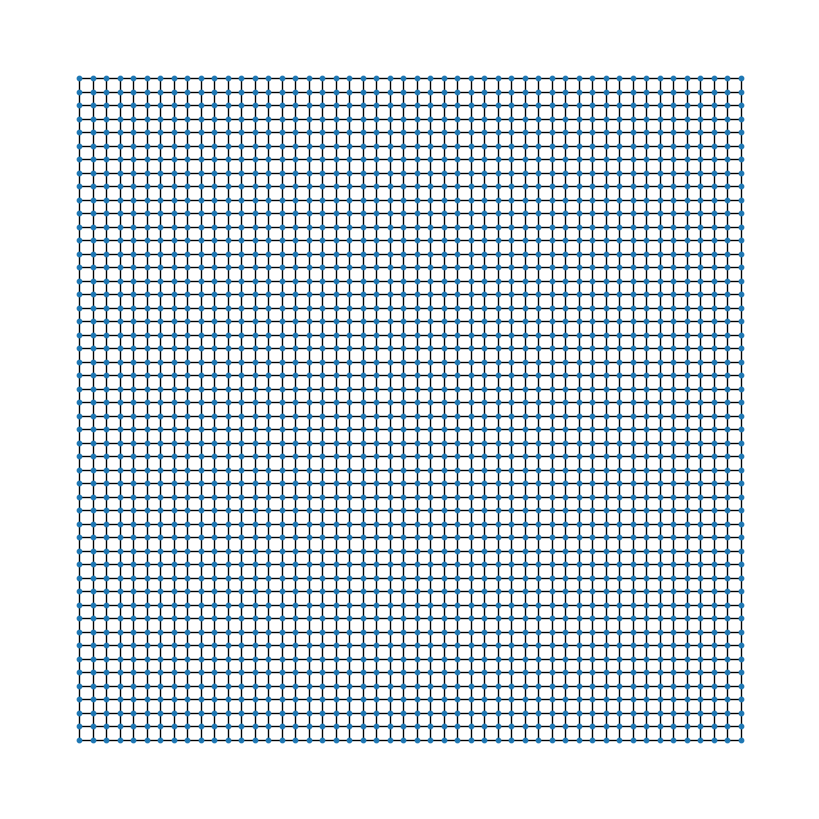

In [9]:
# Visualize the graph -- knowing 2-d structure
draw_2d_grid_graph(Graph_u, px, py, node_size=10)

In [10]:
U = np.zeros((n,p))
for i in range(n):
    U[i,:] = field[i].flatten()

# Compute responses

In [11]:
def h(U_i, j, a=1, b=5):
    return a * U_i[j] + b

In [12]:
m = min(px, py)  # Number of elements on the diagonal
Y = np.zeros((n, m))
a, b = 1.0, 5
for i in range(n):
    U_i = U[i, :]
    for k in range(m):
        j = k * (py + 1)  # Index for the diagonal element in the vectorized field
        Y[i, k] = h(U_i, j, a, b)

# Create observations -- we observe the diagonal in the 2D-field

In [13]:
d = np.repeat(8.0, m)

# Be specific about precision of noise
var_eps = 1.0
Prec_eps = sp.sparse.diags(
    [np.repeat(1/var_eps, m)], 
    offsets=[0],
    shape=(m, m), 
    format='csc'
)

## Ensemble Smoother

In [14]:
def ES(U, Y, d, Cov_epsilon):
    # Cross-covariance matrix C_UY has shape (p, m)
    C_UY = np.dot((U - U.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)
    print(C_UY.shape)

    # Compute the covariance of Y
    # Covariance matrix C_YY has shape (m, m)
    C_YY = np.dot((Y - Y.mean(axis=0)).T, (Y - Y.mean(axis=0))) / (n - 1)

    print(C_YY.shape)

    # Estimated K
    K = C_UY @ np.linalg.inv(C_YY + Cov_epsilon)
    print(K.shape)

    U_posterior = np.copy(U)
    for i in range(n):
        U_posterior[i,:] += K @ (d - Y[i,:])
    
    return U_posterior

In [15]:
U_posterior_es = ES(U, Y, d, np.linalg.inv(Prec_eps.A))

(2500, 50)
(50, 50)
(2500, 50)


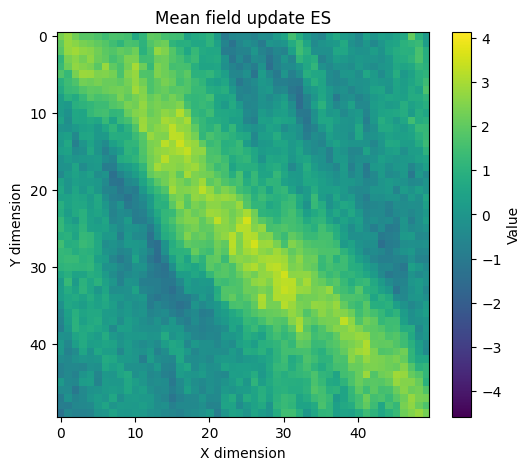

In [16]:
plot_field_from_vector(np.mean(U_posterior_es-U, axis=0), px, py, vmin, vmax, title="Mean field update ES")

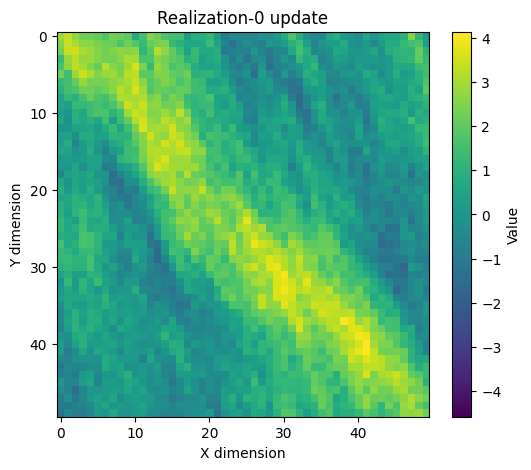

In [17]:
plot_field_from_vector(U_posterior_es[0,:]-U[0,:], px, py, vmin, vmax, title="Realization-0 update")

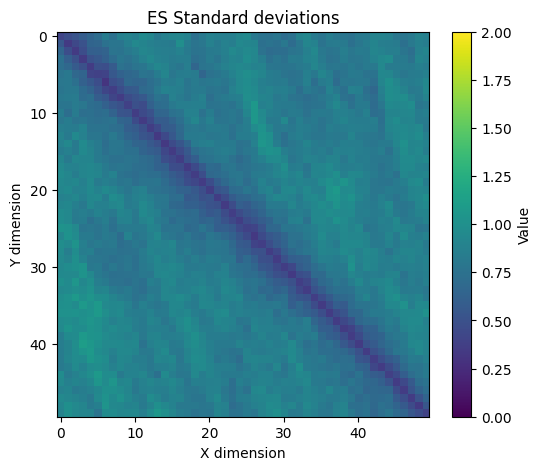

In [18]:
plot_field_from_vector(np.std(U_posterior_es, axis=0), px, py, 0, 2, title="ES Standard deviations")

# Ensemble information filter

In [19]:
# Create EnIF object
gtmap = EnIF(Graph_u = Graph_u, Prec_eps=Prec_eps)

In [20]:
# Fit both precision and sparse linear map H
gtmap.fit(U, Y, learning_algorithm="influence-boost", ordering_method="best", verbose_level=5)
prior_prec_est = gtmap.Prec_u.copy()

/Users/BERL/Github/venv_sksparse/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


max degree of graph is: 4
Permutation optimization took 0.02472519874572754 seconds
Parameters in precision: 7400
Parameters in Cholesky factor: 35913
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2210.63it/s]


Precision has log-determinant: 3472.1306918047676
Learning sparse linear map of shape (50, 2500)


Learning sparse linear map for each response: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 81.16it/s]

Total elements: 125000
Non-zero elements: 50
Fraction of non-zeros: 0.0004
Calculating unexplained variance


In [21]:
#gtmap.fit_precision(U, lambda_l2 = 50.0, verbose_level=5)

In [22]:
U_posterior = gtmap.transport(U, Y, d, verbose_level=5)

Mapping realizations to canonical space
Calculating unexplained variance
Calculating response residuals
Sampling with seed=None
Sampled Gaussian noise with shape (100, 50)
Prior precision log-determinant: 3472.130691804767
Total residual variance: 50.00000000017585
Unexplained variance: 1.7584780459109393e-10
Measurement variance: 50.0
Posterior precision log-determinant: 3492.373984389358
Mapping canonical-scaled realizations to moment realization


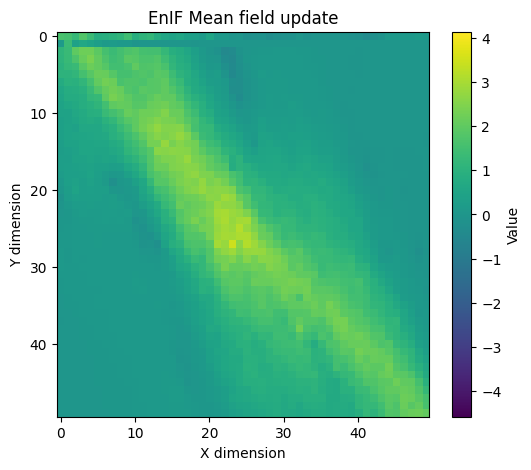

In [23]:
plot_field_from_vector(np.mean(U_posterior-U, axis=0), px, py, vmin, vmax, title="EnIF Mean field update")

In [24]:
vmin, vmax

(-4.573375968554264, 4.1331839374356525)

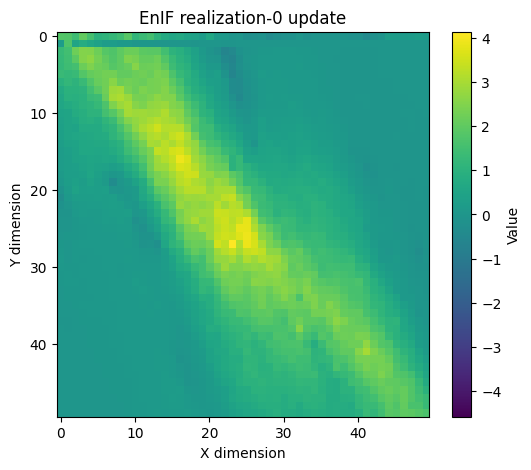

In [25]:
plot_field_from_vector(U_posterior[0,:]-U[0,:], px, py, vmin, vmax, title="EnIF realization-0 update")

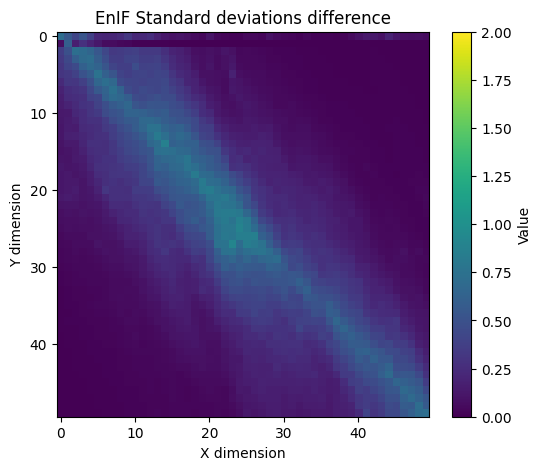

In [26]:
plot_field_from_vector(np.std(U_posterior-U, axis=0), px, py, 0, 2, title="EnIF Standard deviations difference")

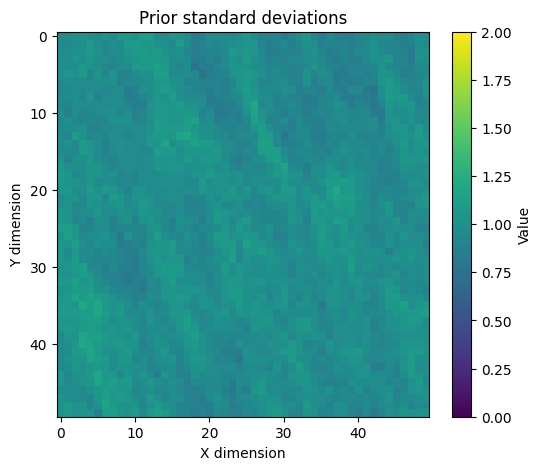

In [27]:
plot_field_from_vector(np.std(U, axis=0), px, py, 0, 2, title="Prior standard deviations")

In [28]:
print(gtmap.H)

  (0, 0)	0.9999980926513672
  (1, 51)	0.9999980926513672
  (2, 102)	0.9999980926513671
  (3, 153)	0.9999980926513672
  (4, 204)	0.9999980926513674
  (5, 255)	0.9999980926513671
  (6, 306)	0.9999980926513673
  (7, 357)	0.9999980926513671
  (8, 408)	0.9999980926513674
  (9, 459)	0.9999980926513672
  (10, 510)	0.9999980926513671
  (11, 561)	0.9999980926513673
  (12, 612)	0.9999980926513673
  (13, 663)	0.999998092651367
  (14, 714)	0.9999980926513672
  (15, 765)	0.9999980926513671
  (16, 816)	0.9999980926513672
  (17, 867)	0.9999980926513673
  (18, 918)	0.9999980926513671
  (19, 969)	0.9999980926513673
  (20, 1020)	0.9999980926513672
  (21, 1071)	0.9999980926513672
  (22, 1122)	0.9999980926513671
  (23, 1173)	0.9999980926513675
  (24, 1224)	0.9999980926513674
  (25, 1275)	0.9999980926513669
  (26, 1326)	0.9999980926513671
  (27, 1377)	0.9999980926513671
  (28, 1428)	0.9999980926513672
  (29, 1479)	0.9999980926513673
  (30, 1530)	0.9999980926513671
  (31, 1581)	0.9999980926513673
  (32, 163

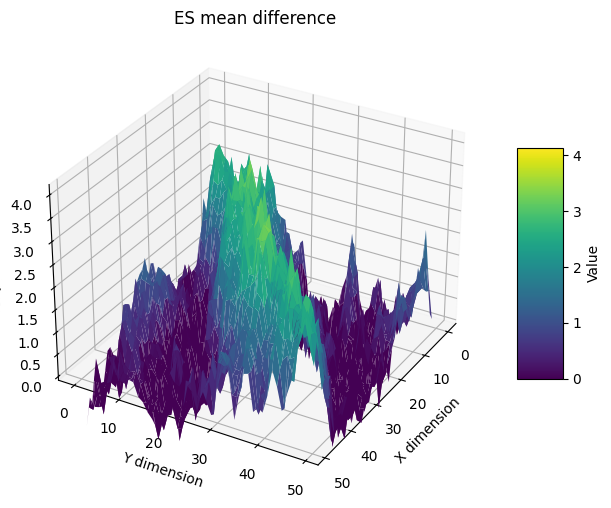

In [29]:
plot_field_3d(np.mean(U_posterior_es-U, axis=0), px, py, 0, vmax, title="ES mean difference")

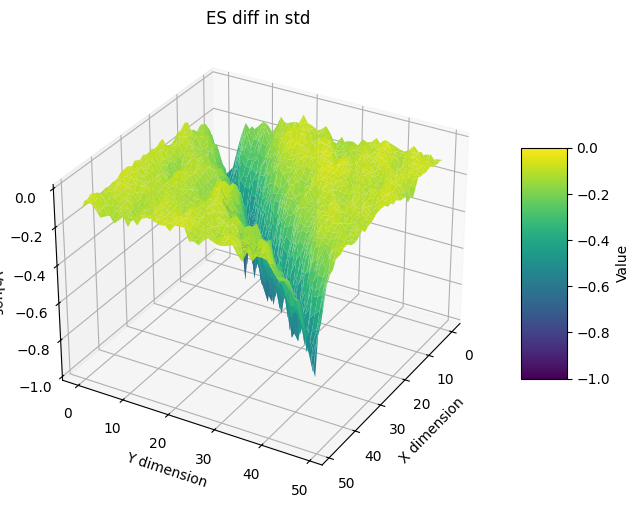

In [30]:
plot_field_3d(np.std(U_posterior_es, axis=0) - np.std(U, axis=0), px, py, -1, 0, title="ES diff in std")

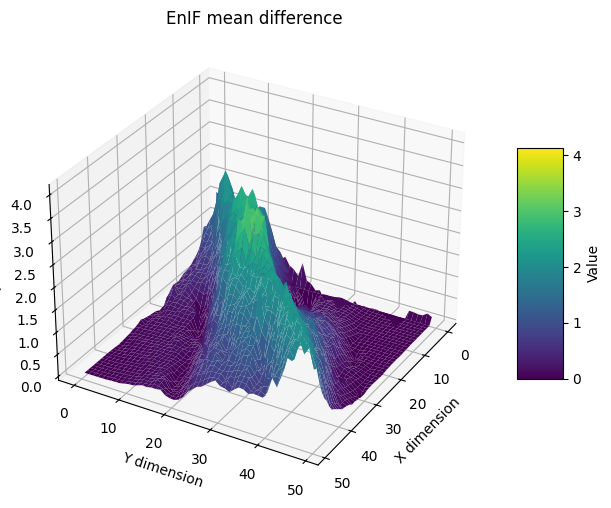

In [31]:
plot_field_3d(np.mean(U_posterior-U, axis=0), px, py, 0, vmax, title="EnIF mean difference")

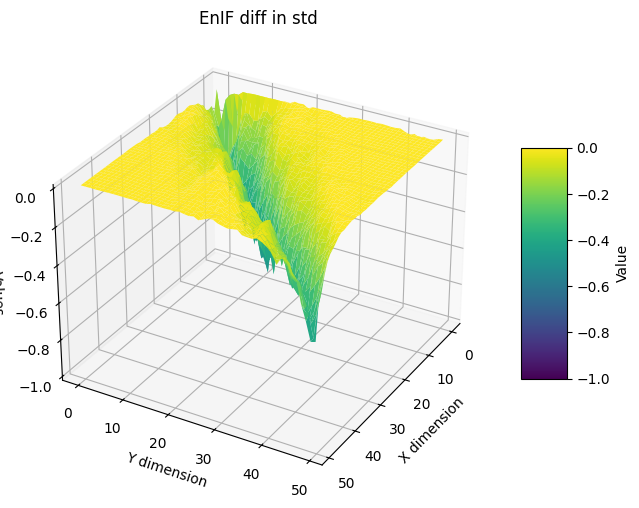

In [32]:
plot_field_3d(np.std(U_posterior, axis=0)-np.std(U, axis=0), px, py, -1.0, 0.0, title="EnIF diff in std")

In [33]:
# Covariance matches the noise added to observations above
covariance = np.linalg.inv(Prec_eps.A) # np.ones(num_observations)  # N(0, 1) covariance

adaptive_smoother = AdaptiveESMDA(
    covariance=covariance,
    observations=d,
    seed=1,
)

In [34]:
X = np.copy(U).T

D = adaptive_smoother.perturb_observations(
    ensemble_size=n, alpha=1.0
)

U_adaptive_posterior = adaptive_smoother.assimilate(
        X=X, Y=Y.T, D=D, alpha=1.0, #correlation_threshold=0.3
    ).T

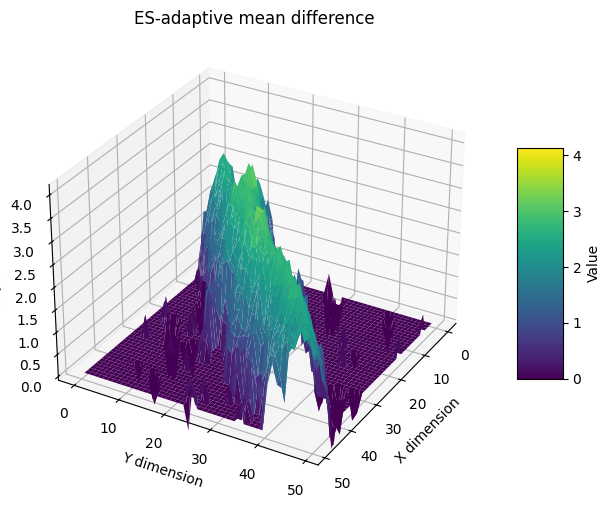

In [35]:
plot_field_3d(np.mean(U_adaptive_posterior-U, axis=0), px, py, 0, vmax, title="ES-adaptive mean difference")

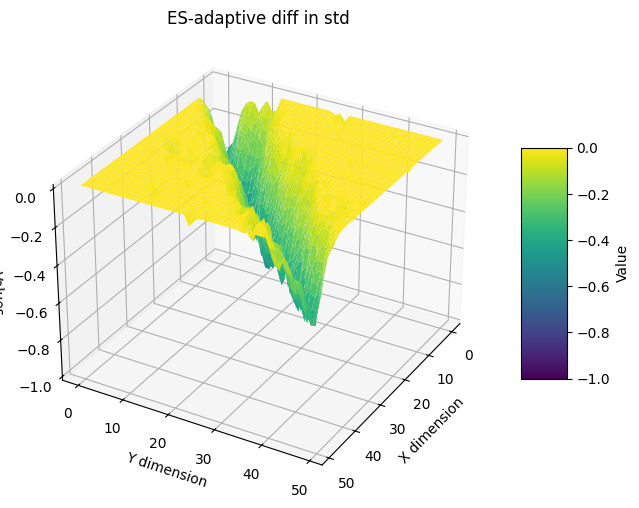

In [36]:
plot_field_3d(np.std(U_adaptive_posterior, axis=0) - np.std(U, axis=0), px, py, -1, 0, title="ES-adaptive diff in std")

In [37]:
np.sqrt(covariance)
np.sqrt(np.diag(covariance))[:, np.newaxis].shape

(50, 1)

In [38]:
from graphite_maps.linear_regression import linear_l1_regression, linear_boost_ic_regression
#X_prior = np.copy(X)
#Y = g(X_prior)
#D = Y + rng.standard_normal(size=Y.shape)
#K = linear_l1_regression(U=D.T, Y=X_prior.T)
Y_noisyT = Y.T + np.random.normal(0, np.sqrt(np.diag(covariance))[:, np.newaxis], Y.T.shape)

In [39]:
K = linear_boost_ic_regression(U=Y_noisyT.T, Y=U)
K.shape

Learning sparse linear map for each response: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:13<00:00, 183.67it/s]


(2500, 50)

In [40]:
d_reshaped = d[:, np.newaxis]  # Reshape to (p, 1)

U_posterior_lr = (U.T + K @ (
    d_reshaped - Y_noisyT
)).T

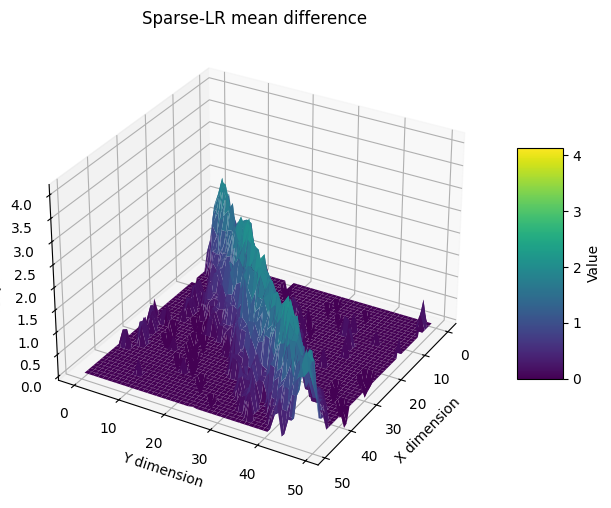

In [41]:
plot_field_3d(np.mean(U_posterior_lr-U, axis=0), px, py, 0, vmax, title="Sparse-LR mean difference")

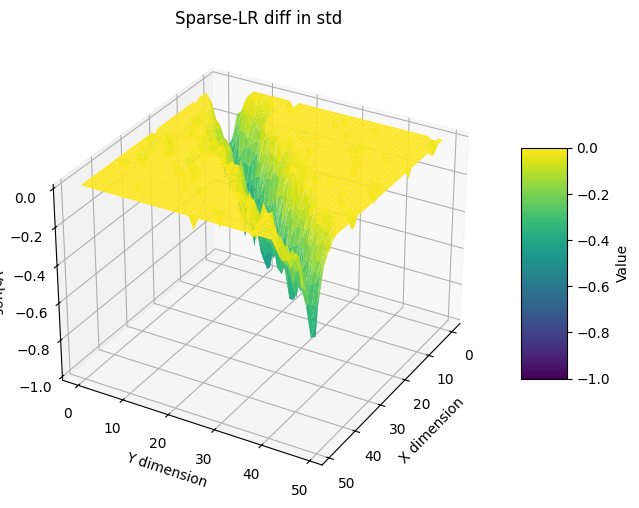

In [42]:
plot_field_3d(np.std(U_posterior_lr, axis=0) - np.std(U, axis=0), px, py, -1, 0, title="Sparse-LR diff in std")